# AOS_DM-45855  update Noll value: rerun calcZernikesDanishCWFSSensor 

In [2]:
import os

import lsst.utils.tests
import numpy as np
from lsst.daf import butler as dafButler
from lsst.ts.wep.task import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
    CombineZernikesMeanTask,
    CombineZernikesSigmaClipTask,
    EstimateZernikesDanishTask,
)
from lsst.ts.wep.task.donutStamps import DonutStamps
from lsst.ts.wep.utils import (
    getModulePath,
    runProgram,
    writeCleanUpRepoCmd,
    writePipetaskCmd,
)

In [4]:
"""
Generate donutCatalog needed for task.
"""

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run1"

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
instrument = "lsst.obs.lsst.LsstCam"
cameraName = "LSSTCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testCalcZernikesCwfsSetupPipeline.yaml"
)

pipeCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
pipeCmd += ' -d "detector IN (191, 192, 195, 196, 199, 200, 203, 204)"'
runProgram(pipeCmd)

lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 3 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 17 quanta, 80 dataset nodes, and 98 edges from 8 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 8 quanta for task isr.
lsst.pipe.base.quantum_graph_builder INFO: Generated 8 quanta for task generateDonutCatalogWcsTask.
lsst.pipe.base.quantum_graph_builder INFO: Generated 1 quantum for task cutOutDonutsCwfsTask.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 17 quanta for 3 tasks, graph ID: '1726695445.1575294-32183'
Quanta            Tasks           
------ ---------------------------
     8                         isr
     8 generateDonutCatalogWcsTask
     1        cutOutDonutsCwfsTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instr

In [5]:
config = CalcZernikesTaskConfig()
config.estimateZernikes.retarget(EstimateZernikesDanishTask)
task = CalcZernikesTask(config=config, name="Base Task")

butler = dafButler.Butler(repoDir)
registry = butler.registry

dataIdExtra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": 4021123106000,
    "visit": 4021123106000,
}
dataIdIntra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": 4021123106000,
    "visit": 4021123106000,
}
donutStampsExtra = butler.get(
    "donutStampsExtra", dataId=dataIdExtra, collections=[runName]
)
donutStampsIntra = butler.get(
    "donutStampsIntra", dataId=dataIdExtra, collections=[runName]
)


In [6]:
donutStampDir = os.path.join(testDataDir, "donutImg", "donutStamps")

# Test R04
donutStampsExtra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R04_SW0_donutStamps.fits")
)
donutStampsIntra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R04_SW1_donutStamps.fits")
)
zernCoeffAllR04 = task.estimateZernikes.run(
    donutStampsExtra, donutStampsIntra
).zernikes
zernCoeffAvgR04 = task.combineZernikes.run(
    zernCoeffAllR04
).combinedZernikes

INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [7]:
len(zernCoeffAvgR04)

25

In [10]:
# previous values 
trueZernCoeffR04 = np.array(
            [
                -0.35353452,
                0.07365128,
                0.62222451,
                -0.06206281,
                0.09065757,
                0.21722746,
                0.20491936,
                0.00849322,
                -0.01150489,
                -0.02599147,
                -0.00150702,
                0.14100845,
                -0.02294787,
                0.02284791,
                -0.02116483,
                -0.02537743,
                -0.01866772,
                0.01653037,
                -0.00552862,
            ]
        )


In [11]:
len(trueZernCoeffR04)

19

Text(0, 0.5, 'Mode value [microns]')

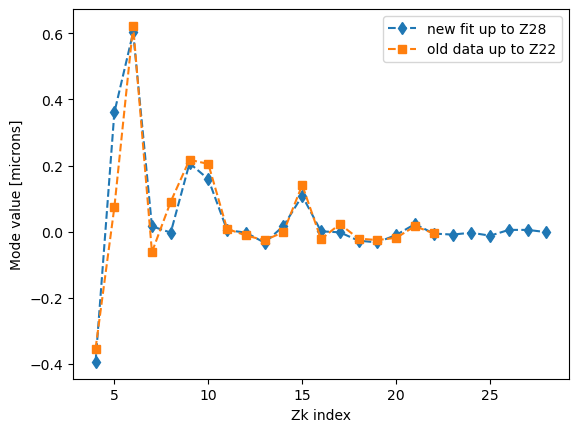

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(4,29), zernCoeffAvgR04, ls='--', marker='d', label='new fit up to Z28')
plt.plot(np.arange(4,23), trueZernCoeffR04, ls='--', marker='s', label='old data up to Z22')
plt.legend()
plt.xlabel('Zk index')
plt.ylabel('Mode value [microns]')

Update the values with the new fit results 

In [13]:
zernCoeffAvgR04

array([-0.39401388,  0.36051539,  0.60247446,  0.01628614, -0.00294667,
        0.20695479,  0.15891274,  0.00473219, -0.00297377, -0.03348815,
        0.01690553,  0.10845509,  0.00102616, -0.00204221, -0.02738544,
       -0.0324347 , -0.01002763,  0.02291608, -0.00589446, -0.00884343,
       -0.00322051, -0.0122419 ,  0.00535912,  0.00531382, -0.00154533])

In [14]:
# Test R40
donutStampsExtra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R40_SW0_donutStamps.fits")
)
donutStampsIntra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R40_SW1_donutStamps.fits")
)
zernCoeffAllR40 = task.estimateZernikes.run(
    donutStampsExtra, donutStampsIntra
).zernikes
zernCoeffAvgR40 = task.combineZernikes.run(
    zernCoeffAllR40
).combinedZernikes
trueZernCoeffR40 = np.array(
    [
        -3.83610201e-01,
        2.06528254e-01,
        5.42893431e-01,
        7.74255848e-02,
        -3.40529812e-02,
        5.45565149e-02,
        -8.65849308e-02,
        1.75029212e-02,
        -1.40149246e-04,
        -4.11223127e-02,
        -2.42644902e-03,
        1.52392233e-01,
        1.24547354e-02,
        -2.33075716e-02,
        -7.35477674e-04,
        1.93518814e-02,
        3.65768735e-03,
        4.12718699e-02,
        -6.93386734e-03,
    ]
)


INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


Text(0, 0.5, 'Mode value [microns]')

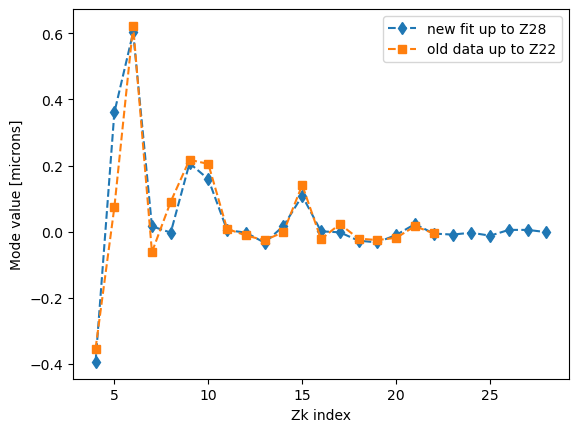

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.arange(4,29), zernCoeffAvgR04, ls='--', marker='d', label='new fit up to Z28')
plt.plot(np.arange(4,23), trueZernCoeffR04, ls='--', marker='s', label='old data up to Z22')
plt.legend()
plt.xlabel('Zk index')
plt.ylabel('Mode value [microns]')

Update the `trueZernCoeffR04` :




In [16]:
zernCoeffAvgR04

array([-0.39401388,  0.36051539,  0.60247446,  0.01628614, -0.00294667,
        0.20695479,  0.15891274,  0.00473219, -0.00297377, -0.03348815,
        0.01690553,  0.10845509,  0.00102616, -0.00204221, -0.02738544,
       -0.0324347 , -0.01002763,  0.02291608, -0.00589446, -0.00884343,
       -0.00322051, -0.0122419 ,  0.00535912,  0.00531382, -0.00154533])

In [ ]:
what's going on now with 


    FAILED tests/task/test_calcZernikesTieTaskCwfs.py::TestCalcZernikesTieTaskCwfs::testEstimateCornerZernikes - ValueError: operands could not be broadcast together with shapes (25,) (19,)
    FAILED tests/task/test_calcZernikesTieTaskCwfs.py::TestCalcZernikesTieTaskCwfs::testWithAndWithoutPairs - AssertionError: 0.25475787071577494 not less than 0.16


? 

Fix these after dinner.




## Fix TestCalcZernikesTieTaskCwfs 

In [17]:
import os

import lsst.utils.tests
import numpy as np
from lsst.daf import butler as dafButler
from lsst.ts.wep.task import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
    CombineZernikesMeanTask,
    CombineZernikesSigmaClipTask,
)
from lsst.ts.wep.task.donutStamps import DonutStamps
from lsst.ts.wep.utils import (
    getModulePath,
    runProgram,
    writeCleanUpRepoCmd,
    writePipetaskCmd,
)

In [19]:

moduleDir = getModulePath()
testDataDir = os.path.join(moduleDir, "tests", "testData")
testPipelineConfigDir = os.path.join(testDataDir, "pipelineConfigs")
repoDir = os.path.join(testDataDir, "gen3TestRepo")
runName = "run1"

# Check that run doesn't already exist due to previous improper cleanup
butler = dafButler.Butler(repoDir)
registry = butler.registry
collectionsList = list(registry.queryCollections())
if runName in collectionsList:
    cleanUpCmd = writeCleanUpRepoCmd(repoDir, runName)
    runProgram(cleanUpCmd)

collections = "refcats/gen2,LSSTCam/calib,LSSTCam/raw/all"
instrument = "lsst.obs.lsst.LsstCam"
cameraName = "LSSTCam"
pipelineYaml = os.path.join(
    testPipelineConfigDir, "testCalcZernikesCwfsSetupPipeline.yaml"
)

pipeCmd = writePipetaskCmd(
    repoDir, runName, instrument, collections, pipelineYaml=pipelineYaml
)
pipeCmd += ' -d "detector IN (191, 192, 195, 196, 199, 200, 203, 204)"'
runProgram(pipeCmd)


lsst.pipe.base.quantum_graph_builder INFO: Processing pipeline subgraph 1 of 1 with 3 task(s).
lsst.pipe.base.quantum_graph_builder INFO: Iterating over query results to associate quanta with datasets.
lsst.pipe.base.quantum_graph_builder INFO: Initial bipartite graph has 17 quanta, 80 dataset nodes, and 98 edges from 8 query row(s).
lsst.pipe.base.quantum_graph_builder INFO: Generated 8 quanta for task isr.
lsst.pipe.base.quantum_graph_builder INFO: Generated 8 quanta for task generateDonutCatalogWcsTask.
lsst.pipe.base.quantum_graph_builder INFO: Generated 1 quantum for task cutOutDonutsCwfsTask.
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 17 quanta for 3 tasks, graph ID: '1726698139.7805176-33105'
Quanta            Tasks           
------ ---------------------------
     8                         isr
     8 generateDonutCatalogWcsTask
     1        cutOutDonutsCwfsTask
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Preparing execution of quantum for label=isr dataId={instr

In [20]:
config = CalcZernikesTaskConfig()
task = CalcZernikesTask(config=config, name="Base Task")

butler = dafButler.Butler(repoDir)
registry = butler.registry

dataIdExtra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": 4021123106000,
    "visit": 4021123106000,
}
dataIdIntra = {
    "instrument": "LSSTCam",
    "detector": 191,
    "exposure": 4021123106000,
    "visit": 4021123106000,
}
donutStampsExtra = butler.get(
    "donutStampsExtra", dataId=dataIdExtra, collections=[runName]
)
donutStampsIntra = butler.get(
    "donutStampsIntra", dataId=dataIdExtra, collections=[runName]
)


In [21]:
# testEstimateCornerZernikes 

donutStampDir = os.path.join(testDataDir, "donutImg", "donutStamps")

# Test R04
donutStampsExtra = DonutStamps.readFits(
os.path.join(donutStampDir, "R04_SW0_donutStamps.fits")
)
donutStampsIntra = DonutStamps.readFits(
os.path.join(donutStampDir, "R04_SW1_donutStamps.fits")
)
zernCoeffAllR04 = task.estimateZernikes.run(
donutStampsExtra, donutStampsIntra
).zernikes
zernCoeffAvgR04 = task.combineZernikes.run(
zernCoeffAllR04
).combinedZernikes

INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [23]:
len(zernCoeffAvgR04)

25

In [24]:
trueZernCoeffR04 = np.array(
            [
                -0.35353452,
                0.07365128,
                0.62222451,
                -0.06206281,
                0.09065757,
                0.21722746,
                0.20491936,
                0.00849322,
                -0.01150489,
                -0.02599147,
                -0.00150702,
                0.14100845,
                -0.02294787,
                0.02284791,
                -0.02116483,
                -0.02537743,
                -0.01866772,
                0.01653037,
                -0.00552862,
            ]
        )

Text(0, 0.5, 'Mode value [microns]')

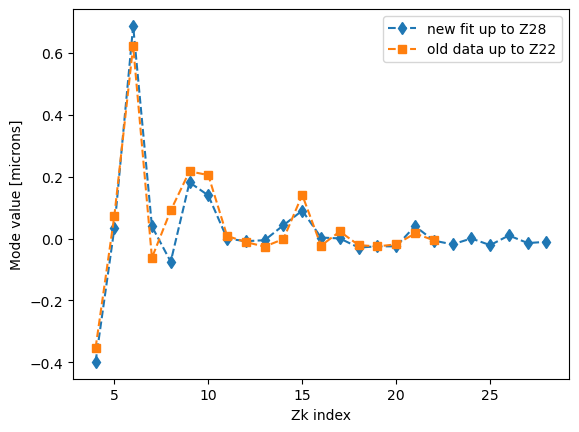

In [25]:
import matplotlib.pyplot as plt
plt.plot(np.arange(4,29), zernCoeffAvgR04, ls='--', marker='d', label='new fit up to Z28')
plt.plot(np.arange(4,23), trueZernCoeffR04, ls='--', marker='s', label='old data up to Z22')
plt.legend()
plt.xlabel('Zk index')
plt.ylabel('Mode value [microns]')

Update with the new values



In [26]:
zernCoeffAvgR04

array([-3.98568849e-01,  3.29880192e-02,  6.86914803e-01,  3.90220393e-02,
       -7.50009174e-02,  1.81549349e-01,  1.39330112e-01,  1.29821719e-05,
       -8.61263006e-03, -5.29780246e-03,  4.29874356e-02,  9.03785421e-02,
        3.26618090e-03,  4.18176969e-04, -2.90643396e-02, -2.52572372e-02,
       -2.51558908e-02,  4.00444469e-02, -6.71305522e-03, -1.87932168e-02,
        2.77894381e-04, -2.12649168e-02,  9.96417120e-03, -1.45702414e-02,
       -1.05431895e-02])

In [27]:
# Test R40
donutStampsExtra = DonutStamps.readFits(
os.path.join(donutStampDir, "R40_SW0_donutStamps.fits")
)
donutStampsIntra = DonutStamps.readFits(
os.path.join(donutStampDir, "R40_SW1_donutStamps.fits")
)
zernCoeffAllR40 = task.estimateZernikes.run(
donutStampsExtra, donutStampsIntra
).zernikes
zernCoeffAvgR40 = task.combineZernikes.run(
zernCoeffAllR40
).combinedZernikes
trueZernCoeffR40 = np.array(
[
    -3.83610201e-01,
    2.06528254e-01,
    5.42893431e-01,
    7.74255848e-02,
    -3.40529812e-02,
    5.45565149e-02,
    -8.65849308e-02,
    1.75029212e-02,
    -1.40149246e-04,
    -4.11223127e-02,
    -2.42644902e-03,
    1.52392233e-01,
    1.24547354e-02,
    -2.33075716e-02,
    -7.35477674e-04,
    1.93518814e-02,
    3.65768735e-03,
    4.12718699e-02,
    -6.93386734e-03,
]
)

INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


Text(0, 0.5, 'Mode value [microns]')

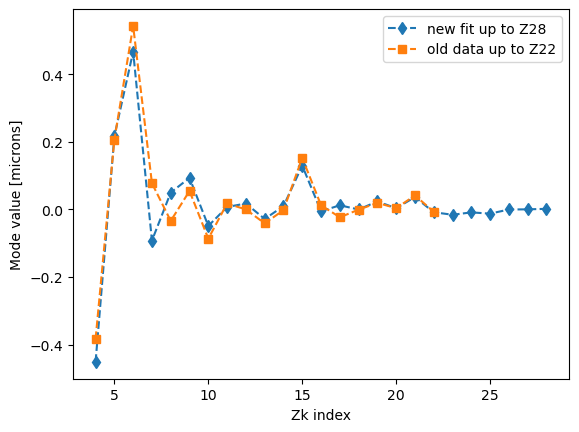

In [28]:
import matplotlib.pyplot as plt
plt.plot(np.arange(4,29), zernCoeffAvgR40, ls='--', marker='d', label='new fit up to Z28')
plt.plot(np.arange(4,23), trueZernCoeffR40, ls='--', marker='s', label='old data up to Z22')
plt.legend()
plt.xlabel('Zk index')
plt.ylabel('Mode value [microns]')

In [29]:
# UPDATE with the new values 

zernCoeffAvgR40


array([-4.51261752e-01,  2.16216207e-01,  4.66819698e-01, -9.23288192e-02,
        4.97984634e-02,  9.33841073e-02, -4.89458314e-02,  7.17956342e-03,
        1.74395927e-02, -2.81949251e-02,  9.53899106e-03,  1.29594074e-01,
       -5.42637866e-03,  1.21212094e-02, -1.66611416e-04,  2.34503797e-02,
        3.56519007e-03,  3.64561520e-02, -8.42437070e-03, -1.58178023e-02,
       -8.84574527e-03, -1.24650851e-02, -2.66815820e-04,  1.86351265e-04,
        1.70769973e-03])

In [32]:
#testWithAndWithoutPairs(self):
# Load the test data
donutStampDir = os.path.join(testDataDir, "donutImg", "donutStamps")
donutStampsExtra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R04_SW0_donutStamps.fits")
)
donutStampsIntra = DonutStamps.readFits(
    os.path.join(donutStampDir, "R04_SW1_donutStamps.fits")
)

# First estimate without pairs
config.estimateZernikes.usePairs = False
config.estimateZernikes.requiresPairs = False
zkAllWithoutPairs = task.estimateZernikes.run(
    donutStampsExtra, donutStampsIntra
).zernikes
zkAvgWithoutPairs = task.combineZernikes.run(
    zkAllWithoutPairs
).combinedZernikes

# Now estimate with pairs
config.estimateZernikes.usePairs = True
zkAllWithPairs = task.estimateZernikes.run(
    donutStampsExtra, donutStampsIntra
        ).zernikes
zkAvgWithPairs = task.combineZernikes.run(zkAllWithPairs).combinedZernikes

# Check that without pairs has at least twice the number of zernikes
#assertEqual(zkAllWithoutPairs.shape[1], zkAllWithPairs.shape[1])
#assertGreaterEqual(zkAllWithoutPairs.shape[0], 2 * zkAllWithPairs.shape[0])

# Check that the averages are similar
diff = np.sqrt(np.sum((zkAvgWithPairs - zkAvgWithoutPairs) ** 2))
#assertLess(diff, 0.16)

INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 2 pairs out of 2 in final Zernike estimate.
INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [38]:
zkAvgWithoutPairs

array([-0.41915955,  0.24427632,  0.81725929,  0.01945347, -0.06229784,
        0.1708392 ,  0.11991285, -0.00763705, -0.02564338, -0.02745559,
        0.02603143,  0.08284261,  0.00170003,  0.00370983, -0.03127467,
       -0.02095989, -0.0175569 ,  0.02317344, -0.00543395, -0.01164542,
        0.00679475, -0.0200987 ,  0.00938908, -0.00413416, -0.00418068])

In [37]:
zkAvgWithPairs

array([-3.98568849e-01,  3.29880192e-02,  6.86914803e-01,  3.90220393e-02,
       -7.50009174e-02,  1.81549349e-01,  1.39330112e-01,  1.29821719e-05,
       -8.61263006e-03, -5.29780246e-03,  4.29874356e-02,  9.03785421e-02,
        3.26618090e-03,  4.18176969e-04, -2.90643396e-02, -2.52572372e-02,
       -2.51558908e-02,  4.00444469e-02, -6.71305522e-03, -1.87932168e-02,
        2.77894381e-04, -2.12649168e-02,  9.96417120e-03, -1.45702414e-02,
       -1.05431895e-02])

Text(0, 0.5, 'Mode value [microns]')

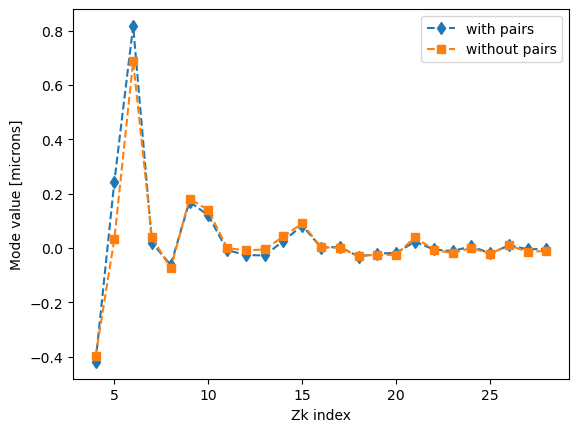

In [40]:
import matplotlib.pyplot as plt
plt.plot(np.arange(4,29), zkAvgWithoutPairs, ls='--', marker='d', label='with pairs')
plt.plot(np.arange(4,29), zkAvgWithPairs, ls='--', marker='s', label='without pairs')
plt.legend()
plt.xlabel('Zk index')
plt.ylabel('Mode value [microns]')


The two are close, there's more absolute difference because we're fitting more modes. 

In [41]:
diff

0.2547578707151876